## Import

In [27]:
import pandas as pd
from config import BASE_DIR, RESULTS_DIR
import matplotlib.pyplot as plt

## Load

In [40]:
garch_df = pd.read_csv(f'{RESULTS_DIR}/metrics/garch_metrics.csv')
xgb_df = pd.read_csv(f'{RESULTS_DIR}/metrics/xgboost_metrics.csv')
garch_pred = pd.read_csv(f'{RESULTS_DIR}/preds/garch_preds.csv')
xgb_pred  = pd.read_csv(f'{RESULTS_DIR}/preds/xgboost_preds.csv')



## Merge data and compare

In [23]:
comparison_df = pd.concat([garch_df, xgb_df], ignore_index=True)
comparison_df = comparison_df.rename(columns={'R_squared': 'R²'})
comparison_df.to_csv(RESULTS_DIR / "metrics" / "model_comparison.csv", index=False)
print(f" Model comparison saved to {RESULTS_DIR / 'metrics' / 'model_comparison.csv'}")

 Model comparison saved to C:\Users\hp\Financial-volatility-forecasting\results\metrics\model_comparison.csv


In [24]:
# Note: For R2, we want to see the increase
baseline_rmse = comparison_df.loc[0, 'rmse']
baseline_mae = comparison_df.loc[0, 'mae']
baseline_r2 = comparison_df.loc[0, 'R²']

new_rmse = comparison_df.loc[1, 'rmse']
new_mae = comparison_df.loc[1, 'mae']
new_r2 = comparison_df.loc[1, 'R²']
rmse_imp = (baseline_rmse - new_rmse) / baseline_rmse * 100
mae_imp = (baseline_mae - new_mae) / baseline_mae * 100
r2_imp = (new_r2 - baseline_r2) / baseline_r2 * 100

print(f"Efficiency Gain: XGBoost reduced RMSE by {rmse_imp:.2f}%")
print(f"Accuracy Gain: XGBoost increased R² by {r2_imp:.2f}%")
comparison_df



Efficiency Gain: XGBoost reduced RMSE by 7.14%
Accuracy Gain: XGBoost increased R² by 108.72%


,model,rmse,mae,R²
0,GARCH,0.107840,0.062151,0.112468
1,XGBoost,0.100136,0.056176,0.234745


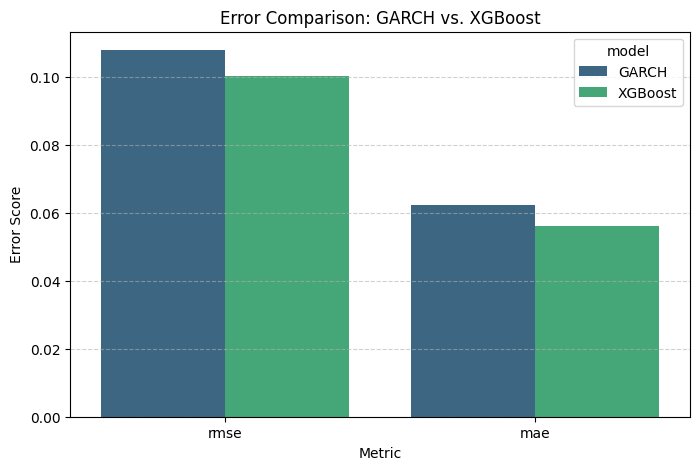

In [31]:
# Melt the dataframe for plotting
plot_data = comparison_df.melt(id_vars='model', value_vars=['rmse', 'mae'], 
                                var_name='Metric', value_name='Score')

import seaborn as sns
plt.figure(figsize=(8, 5))
sns.barplot(data=plot_data, x='Metric', y='Score', hue='model', palette='viridis')

plt.title("Error Comparison: GARCH vs. XGBoost")
plt.ylabel("Error Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig(BASE_DIR / "assets" / "error_comparison.png")

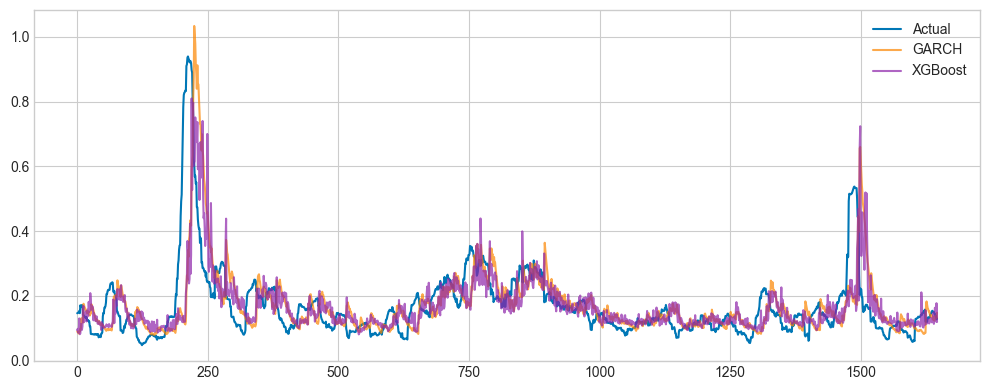

In [58]:
df = pd.DataFrame({
    "target_vol": garch_pred["target_vol"].values,
    "garch_pred": garch_pred["garch_pred"].values,
    "xgb_pred":   xgb_pred["xgb_pred"].values,
})

plt.figure(figsize=(10, 4))
plt.plot(df.index, df["target_vol"], color="#0077B6", label="Actual")
plt.plot(df.index, df["garch_pred"], label="GARCH", color="#FB8500", alpha=0.7)
plt.plot(df.index, df["xgb_pred"], label="XGBoost", color="#8E24AA", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/preds/actual_vs_pred_vol.png", dpi=150)
